<a href="https://colab.research.google.com/github/shivam-kotwalia/data-science-project/blob/master/Active_Learning_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q modAL

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import modAL
import tensorflow_hub as hub
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from modAL import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.metrics import confusion_matrix
from IPython import display
sns.set()

In [3]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [4]:
# Dataset - 
# http://help.sentiment140.com/for-students
! wget -q http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
! unzip -q trainingandtestdata.zip

In [5]:
# Sample of data
! tail training.1600000.processed.noemoticon.csv

"4","2193579249","Tue Jun 16 08:38:59 PDT 2009","NO_QUERY","razzberry5594","WOOOOO! Xbox is back "
"4","2193579284","Tue Jun 16 08:38:59 PDT 2009","NO_QUERY","AgustinaP","@rmedina @LaTati Mmmm  That sounds absolutely perfect... but my schedule is full. I won't have time to lay in bed until Sunday. Ugh!!"
"4","2193579434","Tue Jun 16 08:39:00 PDT 2009","NO_QUERY","sdancingsteph","ReCoVeRiNg FrOm ThE lOnG wEeKeNd "
"4","2193579477","Tue Jun 16 08:39:00 PDT 2009","NO_QUERY","ChloeAmisha","@SCOOBY_GRITBOYS "
"4","2193579489","Tue Jun 16 08:39:00 PDT 2009","NO_QUERY","EvolveTom","@Cliff_Forster Yeah, that does work better than just waiting for it  In the end I just wonder if I have time to keep up a good blog."
"4","2193601966","Tue Jun 16 08:40:49 PDT 2009","NO_QUERY","AmandaMarie1028","Just woke up. Having no school is the best feeling ever "
"4","2193601969","Tue Jun 16 08:40:49 PDT 2009","NO_QUERY","TheWDBoards","TheWDB.com - Very cool to hear old Walt interviews!  ♫ http://blip.fm/~8bm

In [6]:
# Reading only sentiment and tweet
data = pd.read_csv("training.1600000.processed.noemoticon.csv", header=None, encoding="latin-1")[[0, 5]]
data.columns = ["sentiment", "tweet"]
data.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [7]:
def preprocess_text(tweet):
    pattern = r"^@\w*"
    at_rate_name = re.findall(pattern, tweet)
    for at_r in at_rate_name:
        tweet = tweet.replace(at_r, "")
    return tweet

In [8]:
data["tweet"] = data.tweet.apply(preprocess_text)

In [9]:
data.head()

,sentiment,tweet
0,0,"http://twitpic.com/2y1zl - Awww, that's a bum..."
1,0,is upset that he can't update his Facebook by ...
2,0,I dived many times for the ball. Managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why am..."


In [10]:
# 0 - negative 1 - positive
data["sentiment"] = data.sentiment.map({0: 0, 4:1})

In [11]:
# Can't take full data so taking only small chunck 
data_small = data.sample(5_000)
data_small.sentiment.value_counts() 

0    2509
1    2491
Name: sentiment, dtype: int64

In [12]:
tweet_train, tweet_test, label_train, label_test = train_test_split(data_small.tweet, data_small.sentiment, test_size=0.3)

In [13]:
(tweet_train.shape, label_train.shape), (tweet_test.shape, label_test.shape)

(((3500,), (3500,)), ((1500,), (1500,)))

In [14]:
tweet_train_emb = embed(tweet_train).numpy()

In [15]:
tweet_test_emb  = embed(tweet_test).numpy()

In [16]:
tweet_train_emb.shape, tweet_test_emb.shape

((3500, 512), (1500, 512))

In [17]:
n_initial = 50 
pool_tweet, initial_tweet, pool_label, initial_label, pool_tweetText, initial_tweetText = train_test_split(tweet_train_emb, 
                                                                                            label_train,
                                                                                            tweet_train,
                                                                                            test_size = n_initial * 1 / label_train.shape[0])

In [18]:
initial_label   = initial_label.values
pool_label      = pool_label.values
pool_tweetText  = pool_tweetText.values

In [19]:
print(initial_tweet.shape)
print(pool_tweet.shape)

(50, 512)
(3450, 512)


In [20]:
# Distribution of data 
print("Initial Training Data", np.unique(initial_label, return_counts=True))
print("Testing Data", np.unique(label_test, return_counts=True))
print("Pool Data",np.unique(pool_label, return_counts=True))

Initial Training Data (array([0, 1]), array([26, 24]))
Testing Data (array([0, 1]), array([735, 765]))
Pool Data (array([0, 1]), array([1748, 1702]))


In [21]:
learner = ActiveLearner(estimator=RandomForestClassifier(),
                        query_strategy=uncertainty_sampling, 
                        X_training=initial_tweet, 
                        y_training=initial_label)

In [22]:
acc_score = [learner.score(tweet_test_emb, label_test)]
print(acc_score)

[0.6946666666666667]


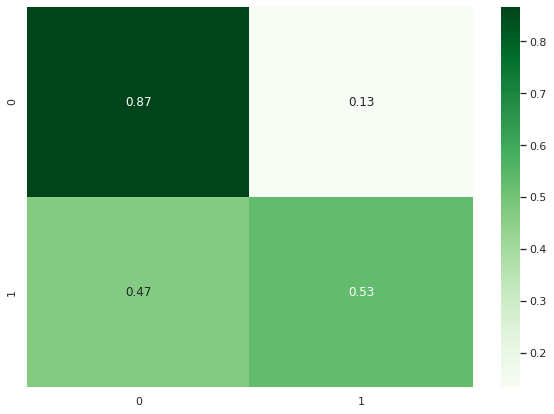

In [23]:
# Confusion Matrix 
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(label_test, 
                             learner.predict(tweet_test_emb), 
                             #labels=np.arange(0, 2), 
                             normalize="true"), 
            annot=True, cmap="Greens")
plt.show()

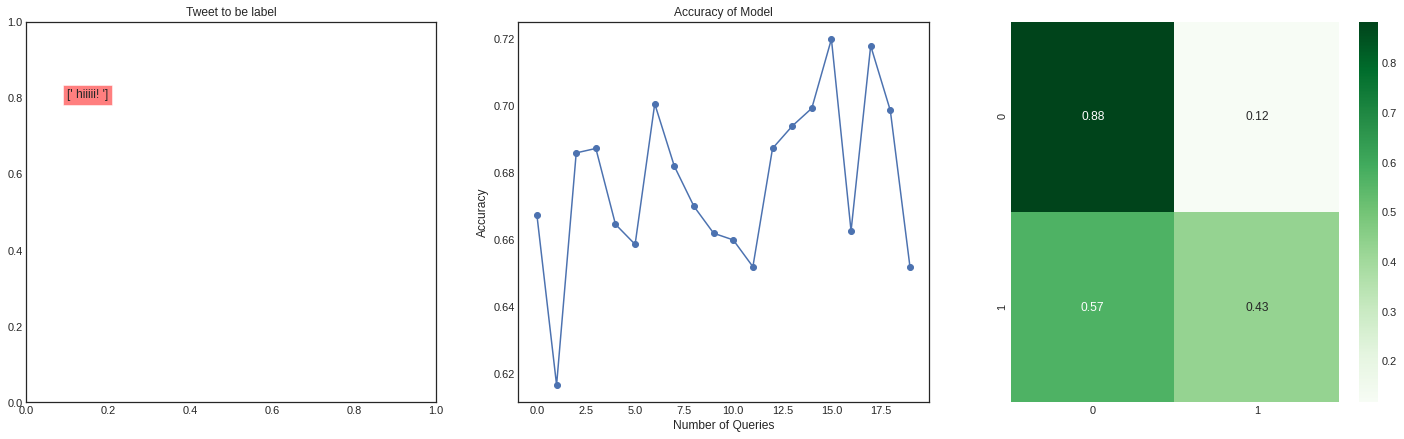

What is the sentiment ??
Correct Answer is : [1]
1


In [26]:
n_query = 20
acc_score = [learner.score(tweet_test_emb, label_test)]


for q in range(n_query):
    display.clear_output(wait=True)
    query_index, query_inst = learner.query(pool_tweet)
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(25, 7))
        
        plt.subplot(1,3,2)
        plt.title("Accuracy of Model")
        plt.plot(range(q+1), acc_score)
        plt.scatter(range(q+1), acc_score)
        plt.xlabel("Number of Queries")
        plt.ylabel("Accuracy")
        
        plt.subplot(1,3,3)
        sns.heatmap(confusion_matrix(label_test, 
                             learner.predict(tweet_test_emb), 
                             labels=np.arange(0, 2), 
                             normalize="true"), 
                    annot=True, cmap="Greens")
        
        plt.subplot(1,3,1)
        plt.title("Tweet to be label")
        plt.text(0.1, 0.8, pool_tweetText[query_index], bbox=dict(facecolor='red', alpha=0.5))
        display.display(plt.gcf())
        plt.close("all")
    
    print("What is the sentiment ??",)
    print("Correct Answer is :", pool_label[query_index])
    label_new = np.array([int(input())], dtype=int)    
    learner.teach(query_inst, label_new)
    pool_tweet, pool_label, pool_tweetText = np.delete(pool_tweet, query_index, axis=0), np.delete(pool_label, query_index, axis=0), np.delete(pool_tweetText, query_index, axis=0)
    acc_score.append(learner.score(tweet_test_emb, label_test))

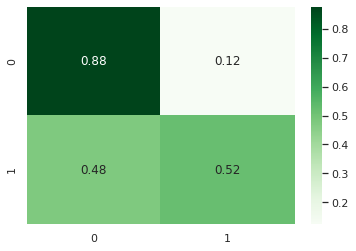

In [25]:
sns.heatmap(confusion_matrix(pool_label, 
                        learner.predict(pool_tweet), 
                        labels=np.arange(0, 2), 
                        normalize="true"), 
            annot=True, cmap="Greens")
plt.show()  